### ao3 - TESTE INGESTÃO DE DADOS DE AVALIAÇÃO DE VINHOS (KAGGLE)
### Candidato - Paulo Franco Filho


### Fonte dos dados: https://www.kaggle.com/zynicide/wine-reviews
### Dicionário
country - País de origem<br>
description - Características do vinho<br>
designation - O Vinhedo dentro da vinicola de onde são provenientes as uvas que fazem o vinho<br>
points - O número de pontos que o WineEnthusiast classificou o vinho em uma escala de 1 a 100 (embora eles digam que só postam avaliações para vinhos com pontuação> = 80)<br>
price - O custo de uma garrafa de vinho<br>
province - Origem do vinho - Provincia ou Estado<br>
region_1 - A área de cultivo de vinho em uma província ou estado<br>
region_2 - Regiões mais específicas especificadas dentro de uma área de cultivo de vinho (ou seja, Rutherford dentro do Vale do Napa), mas este valor pode às vezes estar em branco<br>
taster_name - Nome do degustador<br>
taster_twitter_handle - Twitter do degustador<br>
title  - Nome do vinho<br>
variety - Uva<br>
winery - Vinicola

### Bibliotecas

In [42]:
! pip install pyarrow

In [271]:
#Utilizado pyarrow para trabalhar com arquivos parquet

import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.dataset as ds
import seaborn as sns
import matplotlib.pyplot as plt

# Carrega Dataset origem
Primeiro contato com os dados

In [44]:
df = pd.read_csv("winemag-data-130k-v2.csv",  encoding='UTF-8')
df.shape, df.columns

((129971, 14),
 Index(['Unnamed: 0', 'country', 'description', 'designation', 'points',
        'price', 'province', 'region_1', 'region_2', 'taster_name',
        'taster_twitter_handle', 'title', 'variety', 'winery'],
       dtype='object'))

In [45]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [47]:
df.isnull().sum()

country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

# Cria a Camada 1 - RAW Data
Normalmente utilizaria um particionamento por data, mas como não temos este campo no Dataset optei por parcionar por país que é uma categórica, com poucos valores missing.

### Cria arquivo parquet Camada 1

In [48]:
# Utiliza pyarrow para gerar os arquivos parquet
# Nesta camada os dados serão particionados por país
pa_table = pa.Table.from_pandas(df)
pq.write_to_dataset(pa_table, "parquet_files/Camada_1",partition_cols=['country'])

#Consulta os arquivos gerados
dataset = ds.dataset("parquet_files/Camada_1", format="parquet")
dataset.files

['parquet_files/Camada_1/country=Argentina/b785ff42ee50403d9626e9bbb6a32f0e.parquet',
 'parquet_files/Camada_1/country=Armenia/4c414aa299a04e75ad442775945c277d.parquet',
 'parquet_files/Camada_1/country=Australia/d5f403517cfc4aecbcda65003d34502a.parquet',
 'parquet_files/Camada_1/country=Austria/cdd96c3a5b724cca99b0d5f1dc18d6c9.parquet',
 'parquet_files/Camada_1/country=Bosnia and Herzegovina/875c68ecc4324ef09612a0ab646673ed.parquet',
 'parquet_files/Camada_1/country=Brazil/055440aa26ce450f8c77b8adb6a263cb.parquet',
 'parquet_files/Camada_1/country=Bulgaria/d90a2e7f053e4e56995bc74bfdb54873.parquet',
 'parquet_files/Camada_1/country=Canada/17fa926fe6ba44a7a607748c4154eb7b.parquet',
 'parquet_files/Camada_1/country=Chile/61d7f679017349caa4e8931c7b0dcd77.parquet',
 'parquet_files/Camada_1/country=China/f34bb2e8e1ce4405b90709ddae5586fa.parquet',
 'parquet_files/Camada_1/country=Croatia/7472c3b708cd472db90215673f57278b.parquet',
 'parquet_files/Camada_1/country=Cyprus/bfa48409794e41069e0b6e

# Cria Camada 2

In [194]:
# Consome dados da Camada 1
# Gera dataframe pandas
dataset = ds.dataset("parquet_files/Camada_1/", format="parquet",partitioning="hive")
df = dataset.to_table().to_pandas()
df.shape, df.columns

((129908, 13),
 Index(['description', 'designation', 'points', 'price', 'province', 'region_1',
        'region_2', 'taster_name', 'taster_twitter_handle', 'title', 'variety',
        'winery', 'country'],
       dtype='object'))

In [195]:
# Renomeia colunas
df.rename(columns={'country':'pais', 'description':'descricao','designation':'vinhedo',
    'points':'pontuacao','price':'preco','province':'estado','region_1':'regiao_1',
    'region_2':'regiao_2','taster_name':'degustador','taster_twitter_handle':'twitter','title':'nome_vinho',
    'variety':'tipo_uva','winery':'vinicola'}, inplace=True)

df.head()

,descricao,vinhedo,pontuacao,preco,estado,regiao_1,regiao_2,degustador,twitter,nome_vinho,tipo_uva,vinicola,pais
0,"Baked plum, molasses, balsamic vinegar and che...",Felix,87,30.0,Other,Cafayate,None,Michael Schachner,@wineschach,Felix Lavaque 2010 Felix Malbec (Cafayate),Malbec,Felix Lavaque,Argentina
1,Raw black-cherry aromas are direct and simple ...,Winemaker Selection,87,13.0,Mendoza Province,Mendoza,None,Michael Schachner,@wineschach,Gaucho Andino 2011 Winemaker Selection Malbec ...,Malbec,Gaucho Andino,Argentina
2,With attractive melon and other tropical aroma...,None,88,12.0,Other,Salta,None,Michael Schachner,@wineschach,Alamos 2007 Torrontés (Salta),Torrontés,Alamos,Argentina
3,Blackberry and road-tar aromas are dark and st...,Lunta,90,22.0,Mendoza Province,Luján de Cuyo,None,Michael Schachner,@wineschach,Mendel 2014 Lunta Malbec (Luján de Cuyo),Malbec,Mendel,Argentina
4,"Meaty and rubbery, but that's young Bonarda. T...",None,85,10.0,Mendoza Province,Mendoza,None,Michael Schachner,@wineschach,Andean Sky 2007 Bonarda (Mendoza),Bonarda,Andean Sky,Argentina


In [196]:
# Verifica dados faltantes
df.isnull().sum()

descricao         0
vinhedo       37454
pontuacao         0
preco          8992
estado            0
regiao_1      21184
regiao_2      79397
degustador    26244
twitter       31213
nome_vinho        0
tipo_uva          1
vinicola          0
pais              0
dtype: int64

In [197]:
# pensei em inferir o precos faltantes com base na media de preco 
# de outros vinhos da vinicola mas decidi adortar uma outra abordagem

"""
def infere_preco(param_vinicola):
    df_temp = df[['vinicola','preco']][df['vinicola']==param_vinicola]
    preco = df_temp['preco'].mean()
       return preco

df.loc[df['preco'].isnull(),'preco'] = df['vinicola'].apply(infere_preco)
"""

# Resolvi preencher com zero para uso no filtro em analises q envolvam preco
df.loc[df['preco'].isnull(),'preco'] = 0.00

In [198]:
# dropa colunas q nao serão utilizadas neste momento (nestas analises)
df.drop(['descricao','vinhedo','regiao_1','regiao_2','degustador','twitter'],axis=1, inplace=True)

In [202]:
# remove duplicados
df.drop_duplicates(inplace=True)

In [203]:
df.isnull().sum()

pontuacao     0
preco         0
estado        0
nome_vinho    0
tipo_uva      1
vinicola      0
pais          0
dtype: int64

In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119828 entries, 0 to 129907
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   pontuacao   119828 non-null  int64  
 1   preco       119828 non-null  float64
 2   estado      119828 non-null  object 
 3   nome_vinho  119828 non-null  object 
 4   tipo_uva    119827 non-null  object 
 5   vinicola    119828 non-null  object 
 6   pais        119828 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 7.3+ MB


In [213]:
pa_table = pa.Table.from_pandas(df)
pq.write_to_dataset(pa_table, "parquet_files/Camada_2",partition_cols=['pontuacao','pais'])

#Consulta os arquivos gerados
dataset = ds.dataset("parquet_files/Camada_2", format="parquet")
dataset.schema

preco: double
  -- field metadata --
  PARQUET:field_id: '1'
estado: string
  -- field metadata --
  PARQUET:field_id: '2'
nome_vinho: string
  -- field metadata --
  PARQUET:field_id: '3'
tipo_uva: string
  -- field metadata --
  PARQUET:field_id: '4'
vinicola: string
  -- field metadata --
  PARQUET:field_id: '5'
__index_level_0__: int64
  -- field metadata --
  PARQUET:field_id: '6'
-- schema metadata --
pandas: '{"index_columns": ["__index_level_0__"], "column_indexes": [{"na' + 903

### EDA / Visões

In [245]:
# consome dados camada 2
dataset = ds.dataset("parquet_files/Camada_2/", format="parquet",partitioning="hive")
df_principal = dataset.to_table().to_pandas()

In [247]:
df_principal.shape

(119828, 7)

## Quais os vinhos com melhor pontuacao, origem e preço ?

In [244]:
df = dataset.to_table(filter=ds.field('pontuacao') == 100).to_pandas()

In [252]:
pd.pivot_table(df,index=['pais','nome_vinho'], aggfunc='sum',columns=['pontuacao'],values=['preco'])

preco
pontuacao                                                         100
pais      nome_vinho                                                 
Australia Chambers Rosewood Vineyards NV Rare Muscat (Rut...   350.00
France    Château Cheval Blanc 2010  Saint-Émilion           1,500.00
          Château Haut-Brion 2014  Pessac-Léognan              848.00
          Château Lafite Rothschild 2010  Pauillac           1,500.00
          Château Léoville Barton 2010  Saint-Julien           150.00
          Château Léoville Las Cases 2010  Saint-Julien        359.00
          Krug 2002 Brut  (Champagne)                          259.00
          Louis Roederer 2008 Cristal Vintage Brut  (Cham...   250.00
          Salon 2006 Le Mesnil Blanc de Blancs Brut Chard...   617.00
Italy     Avignonesi 1995 Occhio di Pernice  (Vin Santo d...   210.00
          Biondi Santi 2010 Riserva  (Brunello di Montalc...   550.00
          Casanova di Neri 2007 Cerretalto  (Brunello di ...   270.00
          Tenuta dell'Ornellaia 2007 Masseto Merlot (Tosc...   460.00
Portugal  Casa Ferreirinha 2008 Barca-Velha Red (Douro)        450.00
          Quinta do Noval 2011 Nacional Vintage  (Port)        650.00
US        Cardinale 2006 Cabernet Sauvignon (Napa Valley)      200.00
          Cayuse 2008 Bionic Frog Syrah (Walla Walla Vall...    80.00
          Charles Smith 2006 Royal City Syrah (Columbia V...    80.00
          Verité 2007 La Muse Red (Sonoma County)              450.00

## Quais vinhos com menor pontuacao, origem e preço?

In [358]:
df = dataset.to_table(filter=ds.field('pontuacao') == 80).to_pandas()
df_visao = pd.pivot_table(df,index=['pais','nome_vinho'], aggfunc='sum',columns=['pontuacao'],values=['preco'])
df_visao

preco
pontuacao                                                       80
pais      nome_vinho                                              
Argentina Alfredo Roca 2006 Chardonnay                       10.00
          Alfredo Roca 2007 Sauvignon Blanc                  12.00
          Alma del Sur 2009 Colección Cabernet Sauvignon-... 12.00
          Alta Vista 2007 Finca Monte Lindo Chardonnay (M...  9.00
          Andeluna 2015 1300 Chardonnay (Valle de Uco)       16.00
...                                                            ...
US        Wise Villa 2011 Tempranillo (Sierra Foothills)     29.00
          Wise Villa 2011 Zinfandel (California)             29.00
          Zinsane 2011 Zinfandel (Lodi)                      13.00
Uruguay   Marichal 2012 Premium Varietal Chardonnay (Cane... 16.00
          Pueblo del Sol 2009 Tannat (Juanico)               10.00

[397 rows x 1 columns]

## Quais paises possuem vinhos com preço acima de 500.00 dolares ?

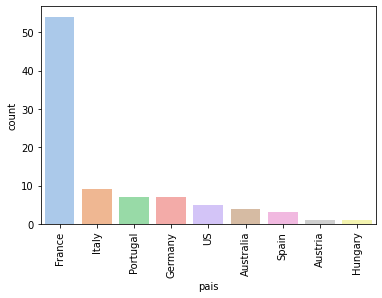

In [376]:
df_visao = df_principal[['pais','preco']][df_principal['preco']>500].sort_values(by=['preco'],ascending=False)

sns.countplot(data = df_visao, x='pais', order=df_visao['pais'].value_counts().index, palette='pastel')

plt.xticks(rotation=90);


## Existe alguma relação entre o preço do vinho e a pontuação recebida? O vinho mais pontuado é o mais caro?

<AxesSubplot:xlabel='pontuacao', ylabel='preco'>

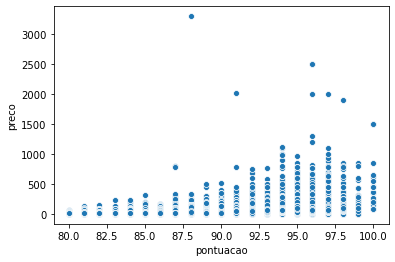

In [397]:
sns.scatterplot(data=df_principal, x='pontuacao', y='preco')

## Como está distribuido a pontuação ? (Histograma da distribuição dos dados relativos a pontuação recebida)

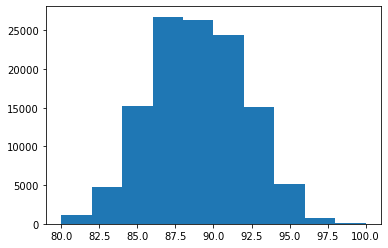

In [386]:
plt.hist(df_principal['pontuacao']);

## Box plot da pontuação
* é possivel notar a mediana um pouco acima de 87,5 - ou seja 50% dos dados tiveram pontuação entre 80 e 88.
* os outros 50% dos dados estão entre 88 e 91
* possível identificar alguns Outliers


<AxesSubplot:xlabel='pontuacao'>

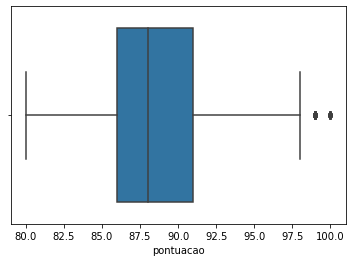

In [390]:
sns.boxplot(data=df_principal, x=df_principal['pontuacao'])

## Quem são os Outliers ?
* Notamos que há vinhos de 80.00 dolare e com pontuação alta

In [426]:
df_visao = df_principal[['pais', 'nome_vinho','pontuacao','preco']][df_principal['pontuacao'] > 99].sort_values(['pontuacao','preco'], ascending=False)
df_visao.head(20)

,pais,nome_vinho,pontuacao,preco
33656,France,Château Lafite Rothschild 2010 Pauillac,100,"1,500.00"
33657,France,Château Cheval Blanc 2010 Saint-Émilion,100,"1,500.00"
35468,France,Château Haut-Brion 2014 Pessac-Léognan,100,848.00
66294,Portugal,Quinta do Noval 2011 Nacional Vintage (Port),100,650.00
29834,France,Salon 2006 Le Mesnil Blanc de Blancs Brut Char...,100,617.00
47116,Italy,Biondi Santi 2010 Riserva (Brunello di Montal...,100,550.00
46082,Italy,Tenuta dell'Ornellaia 2007 Masseto Merlot (Tos...,100,460.00
63109,Portugal,Casa Ferreirinha 2008 Barca-Velha Red (Douro),100,450.00
124680,US,Verité 2007 La Muse Red (Sonoma County),100,450.00
33658,France,Château Léoville Las Cases 2010 Saint-Julien,100,359.00


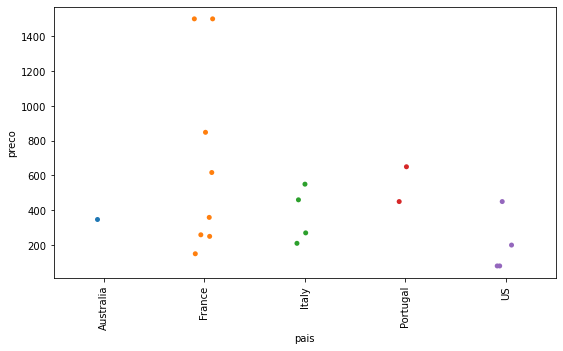

In [421]:
df_visao = df_principal[['pais', 'preco']][df_principal['pontuacao'] > 99]
plt.subplots(figsize=(9,5))
sns.stripplot(data = df_visao, x='pais', y='preco')
plt.xticks(rotation=90);

## Vamos verificar quais paises foram bem pontuados. (Melhores vinhos)
* LEGAL TEMOS VINHO BRASILEIRO NA LISTA

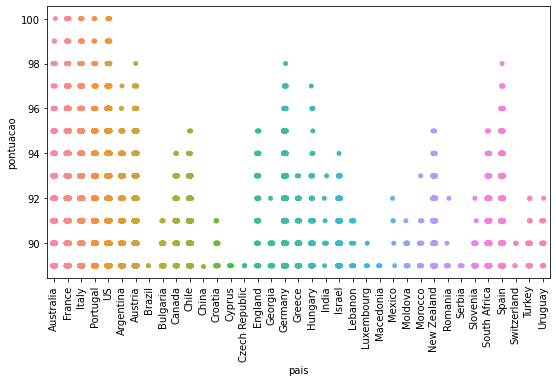

In [404]:
df_visao = df_principal[['pais', 'pontuacao']][df_principal['pontuacao'] > 88]
plt.subplots(figsize=(9,5))
sns.stripplot(data = df_visao, x='pais', y='pontuacao')
plt.xticks(rotation=90);

## Diante disso como está o Brasil nesse conjunto ?
* INFELIZMENTE A MAIORIA DE NOSSOS VINHOS ESTÃO COM NOTA BAIXA

<AxesSubplot:xlabel='pais', ylabel='pontuacao'>

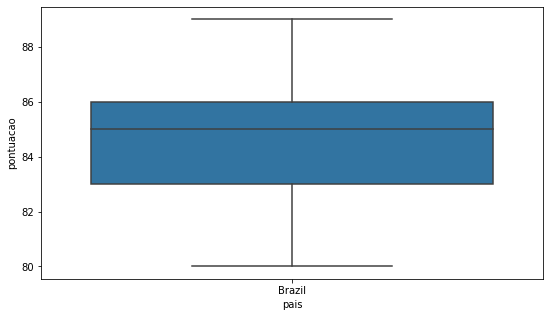

In [408]:
df_visao = df_principal[['pais', 'pontuacao']][df_principal['pais']=='Brazil']
plt.subplots(figsize=(9,5))
sns.boxplot(data=df_visao, y=df_visao['pontuacao'],x=df_visao['pais'])

## Classificação das variáveis
* preco -> Númerica Contínua
* estado -> Categórica nominal
* nome_vinho -> Categórica nominal
* tipo_tuva -> Categórica nominal
* vinicola -> Categórica nominal
* pontuacao -> Categórica nominal
* pais -> Categórica nominal

In [396]:
df_principal.columns

Index(['preco', 'estado', 'nome_vinho', 'tipo_uva', 'vinicola', 'pontuacao',
       'pais'],
      dtype='object')

## Algumas Conclusões

* O formato parquet ocupa menos disco, o acesso aos dados é muito mais rápido (I/O), muito útil para recuperar dados e uso nas visualizações, e fácil de implementar.

* Maioria dos vinhos possuem boa pontuação
* Austrália, França, Itália, Portugal e US -> possuem os vinhos mais bem votados
* 397 vinhos possuem a pontuação miníma
* Os vinhos mais caros são franceses
* Existem vinhos baratos com boa pontuação
* Maioria dos vinhos brasileiros com pontuação baixa



## NOTA: Prentendia explorar mais os dados e utilizar o Streamlit para dataviz, infelizmente devido ao prazo e meu trabalho atual não consegui. Mas espero que gostem do resultado.

## Obrigado !